# Modeling Brain Dynamics in Brain Tumor Patients Using the Virtual Brain  
In this demo, we show how to simulate large-scale brain dynamics using The Virtual Brain, an open-source neuroinformatics platform. 

In [1]:
# load libraries
import csv
import matplotlib.pyplot as plt
import multiprocessing as mp 
import numpy as np
import scipy.io as sio
import scipy.stats as stat
import zipfile
from tvb.simulator.plot.tools import *
from tvb.simulator.lab import *
from tvb.contrib.scripts.models.reduced_wong_wang_exc_io_inh_i import ReducedWongWangExcIOInhI

LOG = get_logger('BrainTumor')

2022-01-30 21:37:34,202 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


In [2]:
%pylab nbagg

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Introduction  
We show how to simulate neural mass model with the reduced Wong-Wang model, using the individual subject connectivity. The global model parameters of the Reduced Wong-Wang model are individually optimized to improve prediction accuracy of functional connectivity.
<br>
Original publication can be found here: https://www.eneuro.org/content/5/3/ENEURO.0083-18.2018  
<br>
When using The Virtual Brain for scientific publications, please cite it as follows:  
<pre><code>Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide,
Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013)
    The Virtual Brain: a simulator of primate brain network dynamics.
Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010)</code></pre>
![](images/workflow.png?raw=true)

## Load Individual Connectivity
Connectivity input data can be found in the github repository: https://github.com/mlion0200/educase_TVB_braintumor, under __demo_data__ folder.  
Data contains functional and structural connectivity matrices of 25 brain tumor patients and 11 healthy control participants before surgery, and 18 brain tumor patients and 10 healthy control participants after neurosurgery.  
<br>
Put Input data folder in the same directory of this python notebook.
Input data needs to follow the directory structure below:
```
TVB_braintumor.ipynb
TVB_input
│   CONXXTX (Control/Patients + number + T1/T2)
│   │   FC.mat
│   │   SCthrAn.mat
│   └───CON02T1_TVB.zip
│       │   areas.txt
│       │   average_orientations.txt
│       │   centres.txt
│       │   cortical.txt
│       │   hemisphere.txt
│       │   tract_lengths.txt.txt
│       │   weights.txt
│   
└───CONXXTX
    │   ...
```

In [3]:
# Set directory path
import os
data_dir = os.path.abspath("TVB_input")
zip_suffix = "_TVB"

In [4]:
def load_connectivity(input_name):
    zip_file_name = input_name + zip_suffix + ".zip"
    dir_name = input_name + zip_suffix
    zip_path = os.path.join(data_dir,  input_name, zip_file_name)
    dir_path = os.path.join(data_dir, input_name, dir_name)
    # Load the connectivity data
    conn = connectivity.Connectivity.from_file(zip_path)
    # Configure, to compute derived data, such as number_of_nodes and delays
    conn.configure()
    
    # Check weight matrix from .zip is corresponding to structural connectivity matrix from matlab file. 
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir_path)
    weight_txt = np.loadtxt(fname = dir_path + "/weights.txt")
    # Load the structural connectivity matrix from matlab file
    SC_path = data_dir + "/" + input_name + "/SCthrAn.mat"
    x = sio.loadmat(SC_path)
    assert np.allclose(x['SCthrAn'], weight_txt), "Weight matrix in weights.txt should be the same as SCthrAn.mat"
    return conn

WARNING  File 'hemispheres' not found in ZIP.


/Library/Anaconda/anaconda3/envs/tumor/lib/python3.9/site-packages/tvb/basic/readers.py:126: UserWarning: loadtxt: Empty input file: "<zipfile.ZipExtFile name='tract_lengths.txt' mode='r' compress_type=deflate>"
  array_result = numpy.loadtxt(file_stream, dtype=dtype, skiprows=skip_rows, usecols=use_cols)


<IPython.core.display.Javascript object>


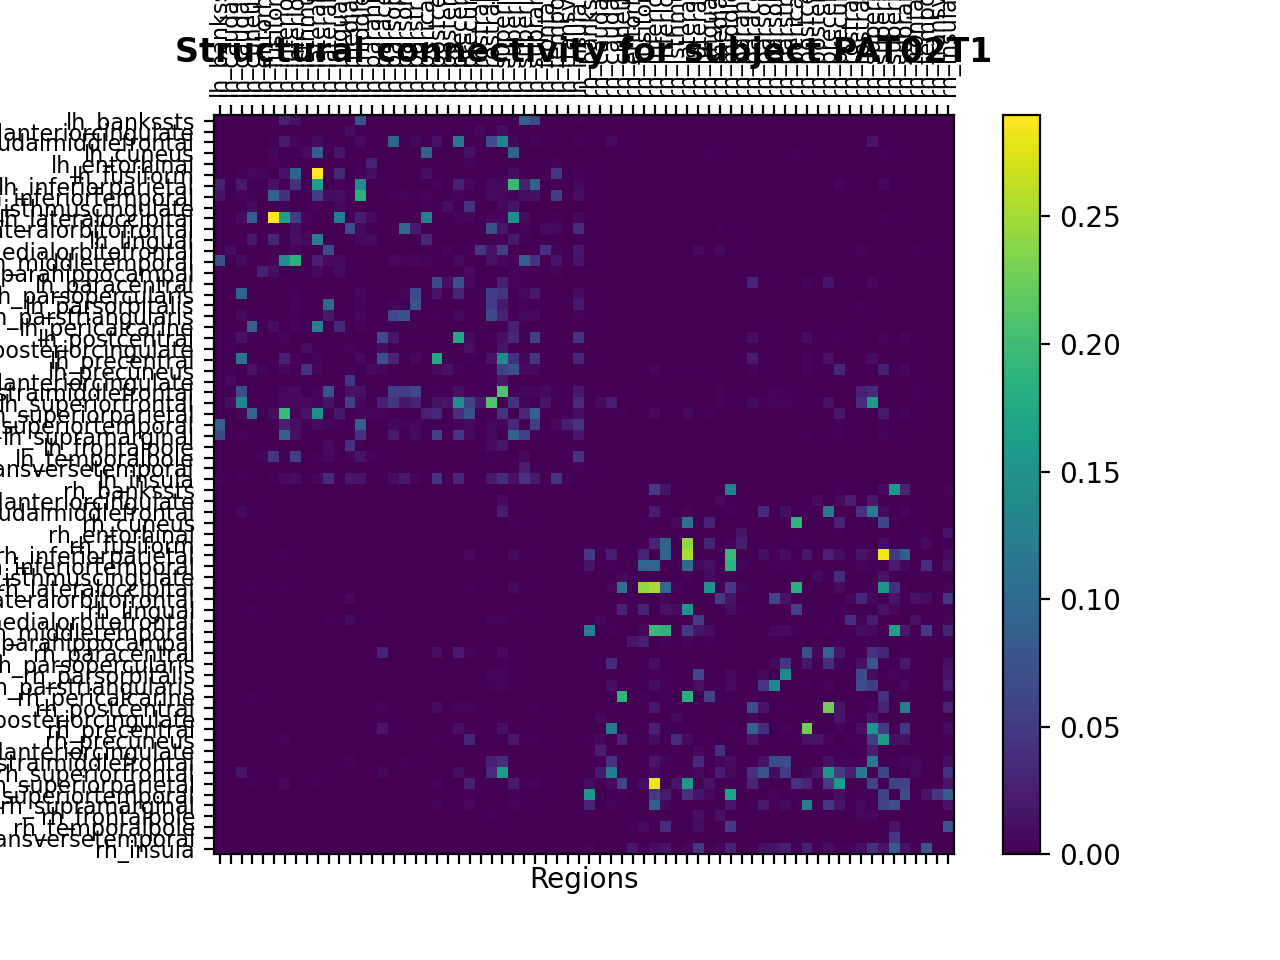

Text(0.5, 1.05, 'Structural connectivity for subject PAT02T1')

In [5]:
# Load the connectivity data
# Set input directory name follows "CONXXTX"
# Controls are the "CONxx", patients are "PATxx", before surgery is denoted with "T1", after surgery is "T2".
input_name = "PAT02T1"
conn = load_connectivity(input_name)
conn.configure()

# Show connectivity summary information.
conn.summary_info

# Plot Structural Connectivity Info: A 2D plot for visualizing the Connectivity.weights matrix
plot_connectivity(connectivity = conn, plot_tracts=False)
plt.xlabel("Regions")
plt.ylabel("Regions")
connectivity_title = "Structural connectivity for subject " + input_name
plt.title(connectivity_title, fontweight="bold", fontsize="12", y = 1.05)

## Load Empirical Functional Connectivity matrix

In [6]:
# get empirical functional connectivity from FC.mat
# in this demo the functional connectivity parameter name is FC_cc_DK68, adjust to your variable name
fc_file_name = os.path.join(data_dir, input_name, "FC.mat")
fc_cc_name = "FC_cc_DK68"
em_fc_matrix = sio.loadmat(fc_file_name)[fc_cc_name]

# indexes of all the values above the diagonal.
uidx = np.triu_indices(68, 1)

# Fisher-Z transform the correlations, important for standardization
em_fc_z = arctanh(em_fc_matrix)
# get the upper triangle since it is symmetric along diagonal
em_fc = em_fc_z[uidx]

<ipython-input-6-b60eeb626412>:11: RuntimeWarning: divide by zero encountered in arctanh
  em_fc_z = arctanh(em_fc_matrix)
<ipython-input-6-b60eeb626412>:11: RuntimeWarning: invalid value encountered in arctanh
  em_fc_z = arctanh(em_fc_matrix)


## Configure Simulator
Reduced Wong-Wang model with an excitatory and an inhibitory population, mutually coupled.  
Following Deco et al 2014.
<br>
Table below shows parameters defined in Reduced Wong-Wang model, default value and description.

| Parameter Name | Default Value   | Description |
|--------------|-------------|-----------|
| a_e            | 310           | Excitatory population input gain parameter (n/C)       |
| b_e     | 125         | Excitatory population input shift parameter (Hz)     |
| d_e     | 0.16        | Excitatory population input scaling parameter (s)   |
| gamma_e | 0.641/1000  | Excitatory population kinetic parameter      |
| tau_e   | 100     | Excitatory population NMDA decay time constant (ms)      |
| w_p   | 1.4     | Excitatory population recurrence weight      |
| J_N   | 0.15     | NMDA current (nA)      |
| W_e   | 1.0     | Excitatory population external input scaling weight      |
| a_i   | 615     | Inhibitory population input gain parameter (n/C)      |
| b_i   | 177     | Inhibitory population input shift parameter (Hz)      |
| d_i   | 0.087     | Inhibitory population input scaling parameter (s)      |
| gamma_i   | 1.0/1000     | Inhibitory population kinetic parameter      |
| tau_i   | 10     | Inhibitory population NMDA decay time constant (ms)      |
| J_i   | 1.0     | Local inhibitory current (nA)      |
| I_o   | 0.382     | Effective external input (nA)      |
| G   | 2.0     | Global coupling scaling (To be optimized)      |
| lamda   | 0.0     | Inhibitory global coupling scaling      |

In [7]:
# set up the Reduced Wong-Wang model
# adjust the parameters to your needs, otherwise it will use the default value shown above
rww = ReducedWongWangExcIOInhI()

In [8]:
# set up the simulator
# adjust the simulation_length to your needs/ available computation time
# in the demo data, time resolution of 2100 or 2400 were used
# a simulation_length of 420,000 or 480,000 were used
# the BOLD monitor in the simulator applies an HRF with convolution during simulation to generate BOLD time series
sim = simulator.Simulator(
    model=rww,
    connectivity=conn,
    coupling=coupling.Linear(),
    integrator=integrators.HeunStochastic(dt=1, noise=noise.Additive(nsig=np.array([1e-5]))), 
    monitors=(
        monitors.TemporalAverage(period=2100.0),
        monitors.Bold(period=2100),
        monitors.ProgressLogger(period=1e5)
    ),
    simulation_length=420000
).configure()

## Run Simulation

In [15]:
def compute_corr(time_line, data_result, sim):
    input_shape = data_result.shape
    result_shape = (input_shape[2], input_shape[2], input_shape[1], input_shape[3])
    sample_period = sim.monitors[1].period
    t_start = sample_period
    t_end = time_line[-1]
    t_lo = int((1. / sample_period) * (t_start - sample_period))
    t_hi = int((1. / sample_period) * (t_end - sample_period))
    t_lo = max(t_lo, 0)
    t_hi = max(t_hi, input_shape[0])
    FC = np.zeros(result_shape)
    for mode in range(result_shape[3]):
        for var in range(result_shape[2]):
            current_slice = tuple([slice(t_lo, t_hi + 1), slice(var, var + 1),
                                   slice(input_shape[2]), slice(mode, mode + 1)])
            data = data_result[current_slice].squeeze()
            FC[:, :, var, mode] = np.corrcoef(data.T)
    return FC
            
def run_sim(global_coupling):
    sim.coupling.a = global_coupling
    print("Starting simulation.. GC =" + str(global_coupling))
    (tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()
    
    # Compute the functional connectivity with the numpy corrcoef analyzer 
    print("Starting corrcoef")          
    FC = compute_corr(bold_time, bold_data, sim)
    # not certain what to do with all models and SV that TVB computes, so we consider the first ones only
    FC = FC[:,:, 0, 0]
            
    # Fisher-Z transform the correlations, important for standardization
    # get the upper triangle since it is symmetric along diagonal
    sim_fc = arctanh(FC)[uidx]
    
    # Calculate the link-wise Pearson correlation between individual’s 
    # upper triangular part of the simulated and empirical functional connectivity matrix
    print("Starting pearsonr")
    try:
        pearson_corr, _ = stat.pearsonr(sim_fc, em_fc)
    except ValueError:
        print("Simulation of Corr ended in Nan...")
        pearson_corr = None

    return (global_coupling, pearson_corr)

In [ ]:
# define global coupling range to explore in simulation
# in the original study a range from 0.01 to 3 with steps of 0.015 was explored
# NOTE: Too many steps will take very long time when running the script on a local computer
# adjust the range of G, or the step size to reduce simulation time
gc_range = np.arange(0.01, 3, 0.29) 
results = []
for gc in gc_range:
    results.append((gc, run_sim(np.array([gc]))))

# run simulation in parallel - be sure that your computer has enough cores
# n_cores = 3 # specify number of cores which should be used in parallel 
# p = mp.Pool(processes=n_cores)
# results = p.map(run_sim, gc_range)
# p.close()

Starting simulation.. GC =[0.01]
   INFO  step 900001 time 900.0010 s
   INFO  step 1000001 time 1000.0010 s
   INFO  step 1100001 time 1100.0010 s
   INFO  step 1200001 time 1200.0010 s
Starting corrcoef
Starting pearsonr
Starting simulation.. GC =[0.3]


<ipython-input-15-297d8479962e>:33: RuntimeWarning: divide by zero encountered in arctanh
  sim_fc = arctanh(FC)[uidx]


   INFO  step 1300001 time 1300.0010 s
   INFO  step 1400001 time 1400.0010 s
   INFO  step 1500001 time 1500.0010 s
   INFO  step 1600001 time 1600.0010 s
Starting corrcoef
Starting pearsonr
Starting simulation.. GC =[0.59]
   INFO  step 1700001 time 1700.0010 s


In [ ]:
# Plot 
g = []
PCorr = []
for result in results:
    g.append(result[0])
    PCorr.append(result[1])
pyplot.xlabel('G')
pyplot.ylabel('Corr')
pyplot.title('G Vs Correlation')

plot(g, PCorr)

Something like this is expected above:

![](images/graph_correlations.png?raw=true)

In [ ]:
# Show optimized G value for the individual subject
optimized_g = g[PCorr.index(max(PCorr))]
print("The optimized G for subject " + input_name + " is " + str(optimized_g))

In [ ]:
# Save G Vs. Correlation results to .csv file
csv_name = input_name + ".csv"
with open(csv_name, 'w') as f:
    writer = csv.writer(f , lineterminator='\n')
    for tup in results:
        writer.writerow(tup)